In [ ]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as spf

In [2]:
spark = SparkSession.builder.appName("anokhin").getOrCreate()

In [3]:
spark

## User-based Collaborative Filtering

### Собираем данные на Spark и сохраняем как pandas dataframe

In [4]:
data = (
    spark.read.json("/user/anokhin/week03/*/")
        .select(spf.col("user"), spf.col("time"), spf.col("recommendation").cast("int").alias("track"))
        .filter(spf.col("track").isNotNull())
        .groupBy(["user", "track"])
        .agg(
            spf.avg("time").alias("time")
        )
).toPandas()

data.head()

,user,track,time
0,4743,42920,1.00
1,8448,48653,0.01
2,5505,8369,0.00
3,1617,22821,0.05
4,4764,33723,0.63


In [6]:
data.to_json("/home/anokhin/data/week03.json", orient="records", lines=True)

### Готовим рекомендации для каждого пользователя

Рекомендовать пользователю треки, которые понравились похожим на него пользователям

$$\hat r_{ui} = h^{-1} \left( \frac{\sum_{v \in N_i(u)} w_{uv} h(r_{vi})}{\sum_{v \in N_i(u)} w_{uv}} \right)$$

$N_i(u)$ - соседи пользователя $u$, которые оценили айтем $i$,
$w_{uv}, w_{ij}$ - веса соседей, 
$h$ - функция нормализации



**Нормализация**: Номализуем так, чтобы вектор пользователя имел единичную длину

**Веса**: Похожих пользователей будем искать по *cosine similarity*

**Соседи**: в качестве соседей будем рассматривать всех пользователей. Q: Как это упростит формулу?

In [1]:
import tqdm
import json

import pandas as pd
import numpy as np

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances

import matplotlib.pyplot as pl
import seaborn as sns

In [2]:
data = pd.read_json("/Users/n.anokhin/Desktop/week03.json", lines=True)

data.head()

,user,track,time
0,6056,30982,0.166667
1,761,12509,0.450000
2,5750,13416,0.410000
3,7023,18160,0.800000
4,5539,23147,0.260000


In [3]:
data["normalized_time"] = data.groupby("user")["time"].transform(lambda time: time / np.sqrt(np.sum(time * time)))

data.head()

,user,track,time,normalized_time
0,6056,30982,0.166667,0.088020
1,761,12509,0.450000,0.167427
2,5750,13416,0.410000,0.132222
3,7023,18160,0.800000,0.195860
4,5539,23147,0.260000,0.079602


In [4]:
interactions = pd.pivot_table(data, values="normalized_time", index="user", columns="track").fillna(0)

print("Interactions matrix: \nshape=" + str(interactions.shape))
print("Sparsity=" + str((interactions != 0).values.sum() / interactions.size))

interactions.head()

Interactions matrix: 
shape=(9940, 46660)
Sparsity=0.0005187835111828278


track,0,1,2,4,5,6,7,8,9,10,...,49989,49990,49991,49992,49993,49994,49995,49996,49997,49999
user,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
similarity_matrix = cosine_similarity(interactions) #Q: Размер?
np.fill_diagonal(similarity_matrix, 0) #Q: Зачем?

print("Mean positive neighbours per user=" + str((similarity_matrix > 0).sum(axis=1).mean()))
print("Mean negative neighbours per user=" + str((similarity_matrix < 0).sum(axis=1).mean()))

Mean positive neighbours per user=79.84285714285714
Mean negative neighbours per user=0.0


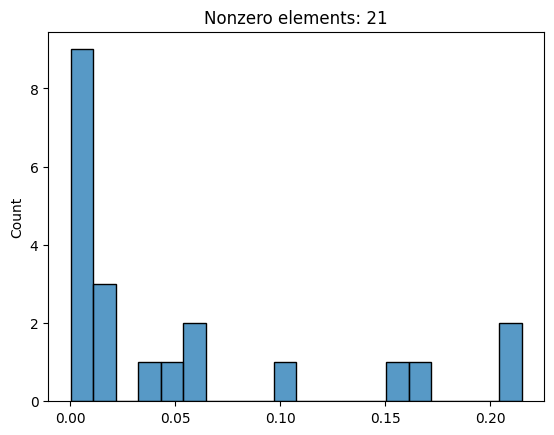

In [6]:
user = 1337

figure, ax = pl.subplots()
sns.histplot(similarity_matrix[user][similarity_matrix[user] > 0], bins=20, ax=ax)

ax.set_title(f"Nonzero elements: " + str((similarity_matrix[user] > 0).sum()))

pass

In [8]:
# TODO: expected size: observed users x observed tracks
scores_matrix = np.matmul(similarity_matrix, interactions.values)

scores = pd.DataFrame(
    scores_matrix,
    index=interactions.index,
    columns=interactions.columns
)

# scores[[0, 1, 2, 3, 4, 5]].head()

#### Глянем на рекомендации

In [9]:
BOTIFY_DATA_DIR = "/Users/n.anokhin/Projects/recsys-course/botify/data/"

In [10]:
tracks = pd.read_json(BOTIFY_DATA_DIR + "tracks.json", lines=True).set_index("track")
tracks.head()

,artist,album,title,genre,pop,duration
track,,,,,,
41164,Михаил Бублик,ART-Обстрел I-часть,Сорок тысяч верст,"[1, 47]",-0.500252,282
27544,Xamdam Sobirov,Baxtli Bo'lolmadik,Baxtli Bo'lolmadik,[1],-0.942953,205
34702,Сергей Какенов,Ишимская шпана,Крутые лагеря,[147],-0.801382,252
45907,Loc-Dog,Electrodog 2,Еду убивать,[17],-0.577525,276
14978,Gafur,Февраль,Февраль,[1],-0.738636,160


In [14]:
user = np.random.choice(scores.index)
k = 10

# data[data["user"] == user].sort_values("time").tail(10)

In [16]:
user_scores = pd.merge(
    scores.loc[user].sort_values(ascending=False)[:k].to_frame("score"),
    tracks, 
    left_index=True, 
    right_index=True,
    how="inner"
)

user_scores # .loc[diff]

,score,artist,album,title,genre,pop,duration
track,,,,,,,
42570,0.490964,Фабрика,Не родись красивой,Лодочка,[1],-0.675339,258
35230,0.355339,Фабрика,Не родись красивой,Я тебя зацелую (Fedor Fomin & Noel Di Remix long),[1],-0.626732,290
39259,0.335208,Фабрика,Не родись красивой,А я за тобой,[1],0.247543,250
30337,0.322137,Фабрика,Мы такие разные (remix),Мы такие разные (remix),[1],-0.474067,212
33121,0.306663,Фабрика,ФАБРИКА - Могла как могла,Могла как могла,[1],-0.047856,192
40787,0.303897,Фабрика,Не родись красивой,Полюбила,[1],-0.542321,197
34081,0.287856,Фабрика,Вова Вова,Вова Вова,[1],-0.723860,171
26868,0.277766,Фабрика,Мама молодая,Мама молодая,[1],0.613733,227
42929,0.244732,Фабрика,Не родись красивой,Секрет,[1],0.034290,228


In [17]:
user_interactions = pd.merge(
    interactions.loc[user].sort_values(ascending=False).to_frame("time"),
    tracks, 
    left_index=True, 
    right_index=True, 
    how="inner"
)

user_interactions[user_interactions["time"] != 0]

,time,artist,album,title,genre,pop,duration
track,,,,,,,
31924,0.306737,IVAN VALEEV,Заберу (Frost & Robby Mond & Wonder's Radio Re...,Заберу (Frost & Robby Mond & Wonder's Radio Re...,[10],0.480688,195
8457,0.306737,Тамара Кутидзе,На всю жизнь,На всю жизнь,[1],-0.871158,168
35958,0.306737,Фабрика,Девушки фабричные,Про любовь,[1],-0.683809,237
34460,0.306737,HOMIE,Эгоист,Эгоист,[1],0.308602,184
29758,0.306737,IVAN VALEEV,Непростая,Непростая,[1],-0.843476,213
26868,0.306737,Фабрика,Мама молодая,Мама молодая,[1],0.613733,227
32543,0.306737,Andery Toronto,WeLove,Пьяная,[1],0.755575,170
16657,0.245389,Тамара Кутидзе,Женщина,Женщина,[1],0.132182,200
42570,0.233120,Фабрика,Не родись красивой,Лодочка,[1],-0.675339,258


In [18]:
# diff = set(recommended_tracks).difference(interaction_tracks)

## Подготавливаем рекомендации для продакшена

In [19]:
def recommend(user_id, scores, k):
    return scores.loc[user_id].sort_values(ascending=False)[:k].index.tolist()

In [20]:
users = data["user"].unique()

with open(BOTIFY_DATA_DIR + "recommendations_ub.json", "w") as rf:
    for user in tqdm.tqdm(users):
        recommendation = {
            "user": int(user),
            "tracks": recommend(user, scores, 100)
        }
        rf.write(json.dumps(recommendation) + "\n")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9940/9940 [00:21<00:00, 453.41it/s]
